<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Jayne/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
#Load the data from pkl files
def load_data_from_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        sample_df = pickle.load(f)
    return sample_df

df = load_data_from_pkl('/content/drive/MyDrive/disaster_data.pkl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# # images = np.array([np.array(image) for image in images])
# type(images)

list

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

5831
5831
5831


In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

,image,text,label
0,"[[[[0.82352941 0.90588235 0.97254902], [0.8235...",#isiscrimes \nIsis dogs crucified a men accuse...,isiscrimes
1,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Part 2:\n\nIn January of this year Abu Rayyan ...,isiscrimes
2,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Wake up.ppl see the reality to what ISIS is al...,isiscrimes
3,"[[[[0.58823529 0.44705882 0.34509804], [0.5803...",New image from akhtarin in aleppo #Syria yeste...,isiscrimes
4,"[[[[0.4627451 0.38039216 0.2745098 ], [0.4627...",Syria #Aleppo ISIS continue on with their behe...,isiscrimes


In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })

In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.14509804 0.12941176 0.03137255], [0.1450...",#vulcan#vulcaninsel#instagram#instavulcan#volc...,earthquake,earthquake,damage
5297,"[[[[0.91372549 0.91372549 0.96078431], [0.9137...",Making the best of the flood waters this morni...,floodwater,flood,damage
1121,"[[[[0.98431373 0.98431373 0.98431373], [0.9843...",*كلام حلو* .\n.\n\n#streetworkout #streetstyle...,ad,non-damage,non-damage
561,"[[[[0.97647059 0.97647059 0.97647059], [0.9568...",do you like this😜😜\n#\n.\nvia @freschle\n.\n.\...,treefalling,hurricane,damage
1188,"[[[[0.04705882 0.0627451 0.10588235], [0.0392...",WhatsApp On +919466780004 #earrings #jhumki #c...,ad,non-damage,non-damage


In [ ]:
df['label_3'].value_counts()

,count
label_3,
non-damage,513
damage,487


In [ ]:
# sample_df = df.sample(n=1000, random_state=42)
# sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
# sample_df['label_3'].value_counts()

,count
label_3,
non-damage,513
damage,487


In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.14509804 0.12941176 0.03137255], [0.1450...",#vulcan#vulcaninsel#instagram#instavulcan#volc...,earthquake,earthquake,damage
5297,"[[[[0.91372549 0.91372549 0.96078431], [0.9137...",Making the best of the flood waters this morni...,floodwater,flood,damage
1121,"[[[[0.98431373 0.98431373 0.98431373], [0.9843...",*كلام حلو* .\n.\n\n#streetworkout #streetstyle...,ad,non-damage,non-damage
561,"[[[[0.97647059 0.97647059 0.97647059], [0.9568...",do you like this😜😜\n#\n.\nvia @freschle\n.\n.\...,treefalling,hurricane,damage
1188,"[[[[0.04705882 0.0627451 0.10588235], [0.0392...",WhatsApp On +919466780004 #earrings #jhumki #c...,ad,non-damage,non-damage


#New Data

In [ ]:
# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        image = np.array(image) / 255.0  # Normalize pixel values
        return np.expand_dims(image, axis=0)  # Add batch dimension (1, 250, 250, 3)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
folder = '/content/drive/MyDrive/Sample Pictures'
images = []
# Get and sort image files
image_files = sorted([file for file in os.listdir(folder) if file.endswith(('jpg', 'jpeg', 'png'))])
# Process each image
for image_file in image_files:
    image_path = os.path.join(folder, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        images.append(processed_image)

In [ ]:
images[0].shape

(1, 250, 250, 3)

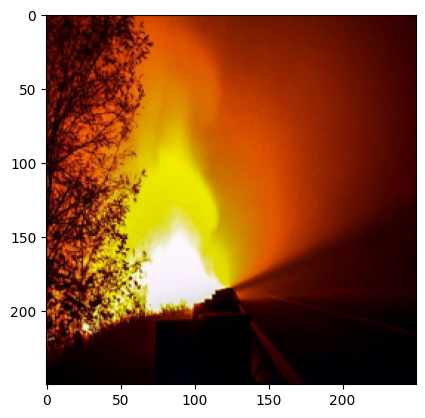

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((images[18][0] * 255).astype('uint8'))

In [ ]:
data = pd.DataFrame({'image': images})
data.head()

,image
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725..."
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058..."
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745..."
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686..."
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235..."


In [ ]:
# Create a mapping dictionary for the indices
index_to_label = {
    0: 'flood',
    1: 'human',
    2: 'human',
    3: 'human',
    4: 'human',
    5: 'building collapse',
    6: 'building collapse',
    7: 'building collapse',
    8: 'fire',
    9: 'fire',
    10: 'building collapse',
    11: 'flood',
    12: 'drought',
    13: 'drought',
    14: 'drought',
    15: 'drought',
    16: 'flood',
    17: 'flood',
    18: 'fire',
    19: 'fire'
}
data['label'] = [index_to_label[i] for i in range(len(data))] # Display the first few rows of the DataFrame to check the resultprint(data.head())


In [ ]:
data.head(10)

,image,label
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725...",flood
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058...",human
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745...",human
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686...",human
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235...",human
5,"[[[[0.63137255 0.85490196 0.97254902], [0.6313...",building collapse
6,"[[[[0.91764706 0.91764706 0.91764706], [0.9176...",building collapse
7,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...",building collapse
8,"[[[[0.05490196 0.03921569 0.00392157], [0.0549...",fire
9,"[[[[0.02352941 0.00392157 0. ], [0.0313...",fire


In [ ]:
data['label_2'] = data['label'].replace({'flood': 'non-flood',
                                         'building collapse': 'non-flood',
                                         'drought': 'non-flood',
                                         'human': 'non-flood'})


In [ ]:
data.head(20)

,image,label,label_2
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725...",flood,non-flood
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058...",human,non-flood
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745...",human,non-flood
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686...",human,non-flood
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235...",human,non-flood
5,"[[[[0.63137255 0.85490196 0.97254902], [0.6313...",building collapse,non-flood
6,"[[[[0.91764706 0.91764706 0.91764706], [0.9176...",building collapse,non-flood
7,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...",building collapse,non-flood
8,"[[[[0.05490196 0.03921569 0.00392157], [0.0549...",fire,fire
9,"[[[[0.02352941 0.00392157 0. ], [0.0313...",fire,fire


In [ ]:
data['image'][0][0].shape

(250, 250, 3)

In [ ]:
X = data['image']
y = data['label_2']

In [ ]:
# X = np.array(img[0] for img in X)

In [ ]:
X = np.array(data['image'].tolist())  # Convert the image column to a NumPy array
y = data['label_2'].values  # Convert labels to NumPy array

# Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Check the shapes of the training and test data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (15, 1, 250, 250, 3)
X_test shape: (5, 1, 250, 250, 3)
y_train shape: (15,)
y_test shape: (5,)


In [ ]:
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to numeric
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
#Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()
# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# Add fully connected layers
model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.03)))  # L2 regularization
model.add(Dropout(0.5))  # Optional dropout for regularization
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │      15,241,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,266,945 (58.24 MB)

 Trainable params: 15,266,945 (58.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6000 - loss: 4.5124
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8000 - loss: 7.3418
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8000 - loss: 4.2950
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7333 - loss: 3.4519
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 2.8264
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 2.5133
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 2.1189
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 2.2061
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 2.1575
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 2.0620


In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.9306


[1.9305616617202759, 1.0]

#Damage and non-damage on large dataset

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 79.2+ KB


In [28]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.14509804 0.12941176 0.03137255], [0.1450...",#vulcan#vulcaninsel#instagram#instavulcan#volc...,earthquake,earthquake,damage
5297,"[[[[0.91372549 0.91372549 0.96078431], [0.9137...",Making the best of the flood waters this morni...,floodwater,flood,damage
1121,"[[[[0.98431373 0.98431373 0.98431373], [0.9843...",*كلام حلو* .\n.\n\n#streetworkout #streetstyle...,ad,non-damage,non-damage
561,"[[[[0.97647059 0.97647059 0.97647059], [0.9568...",do you like this😜😜\n#\n.\nvia @freschle\n.\n.\...,treefalling,hurricane,damage
1188,"[[[[0.04705882 0.0627451 0.10588235], [0.0392...",WhatsApp On +919466780004 #earrings #jhumki #c...,ad,non-damage,non-damage


In [29]:
X_image = df['image']

resized_X_image = []

for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

X_images = np.array(resized_X_image)

In [31]:
# X_dat = np.array(df['image'].tolist())
# Convert the image column to a NumPy array
X_data = np.array([np.squeeze(image, axis=0) if image.shape[0] == 1 else image for image in X_images])

y_data = df['label_3'].values  # Convert labels to NumPy array

# Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)

# Check the shapes of the training and test data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (750, 250, 250, 3)
X_test shape: (250, 250, 250, 3)
y_train shape: (750,)
y_test shape: (250,)


In [ ]:
# X_train = np.squeeze(X_train, axis=1)
# X_test = np.squeeze(X_test, axis=1)

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [32]:
# Convert categorical labels to numeric
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()
# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# Add fully connected layers
model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.03)))  # L2 regularization
model.add(Dropout(0.5))  # Optional dropout for regularization
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,241,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,266,945 (58.24 MB)

 Trainable params: 15,266,945 (58.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# X_train = np.squeeze(X_train, axis=1)
# X_test = np.squeeze(X_test, axis=1)

# Now you can proceed with fitting your model
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.5035 - loss: 3.2000
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5091 - loss: 0.9780
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5346 - loss: 0.7455
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4959 - loss: 0.7415
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.5396 - loss: 0.7288
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5493 - loss: 0.7256
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5492 - loss: 0.7193
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5270 - loss: 0.7495
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.5075 - loss: 0.7415
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.5364 - loss: 0.7068


In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - accuracy: 0.8000 - loss: 2.0080


[2.0079517364501953, 0.800000011920929]

In [ ]:
predictions = model.predict(X_test_image)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 676ms/step


In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50


# Define the input shape of the images (224x224 with 3 channels)
input_shape = (250, 250, 3)  # Changed to the standard ResNet50 input shape

# Create a sequential model
resnet_model = Sequential()

# Add the ResNet50 model, excluding the top layers, and set weights to ImageNet
resnet_model.add(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))

# Freeze the layers of the pre-trained model to avoid updating them during training
for layer in resnet_model.layers:
    layer.trainable = False

# Flatten the output layer to 1D
resnet_model.add(Flatten())

# Add a fully connected layer with dropout for regularization
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dropout(0.5))

# Add the output layer for binary classification (sigmoid for 1 output)
resnet_model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
resnet_model.summary()

ValueError: Undefined shapes are not supported.

In [35]:
from tensorflow.keras.optimizers import Adam

# Define the input shape of the images (250x250 with 3 channels)
input_shape = (250, 250, 3)

# Create a sequential model
resnet_model = Sequential()

# Add the ResNet50 model, excluding the top layers, and set weights to ImageNet
resnet_model.add(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))

# Flatten the output layer to 1D
resnet_model.add(Flatten())

# Add a fully connected layer with dropout for regularization
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dropout(0.5))

# Add the output layer for binary classification (sigmoid for 1 output)
resnet_model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
resnet_model.summary()

ValueError: Undefined shapes are not supported.

In [ ]:
def create_cnn_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

cnn_model = create_cnn_model()

# # Extract features from images
# image_features = cnn_model.predict(images)

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
cnn_model.fit(X_train_image, y_train, epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.5065 - loss: 0.7226
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.5902 - loss: 0.6732
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - accuracy: 0.5242 - loss: 0.6934
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.6341 - loss: 0.6493
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.6140 - loss: 0.6553
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.6192 - loss: 0.6319
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - accuracy: 0.6087 - loss: 0.6370
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.6234 - loss: 0.6476
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.6594 - loss: 0.6292
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.6338 - loss: 0.6283


In [ ]:
def create_cnn_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(320, 320, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
    ])

    return model

cnn_model = create_cnn_model()

# Extract features from images
image_features = cnn_model.predict(images)
print(image_features.shape)  # Should return (num_images, 256) for example


# LSTM for text processing
def create_lstm_model(vocab_size, embedding_dim, sequence_length):
    text_input = Input(shape=(sequence_length,))
    x = Embedding(vocab_size, embedding_dim, input_length=sequence_length)(text_input)
    x = LSTM(128)(x)
    return text_input, x

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
sequence_length = max_sequence_length

text_input, text_features = create_lstm_model(vocab_size, embedding_dim, sequence_length)

# Combine image features and text features
combined_features = Concatenate()([image_features, text_features])
combined_output = Dense(128, activation='relu')(combined_features)
final_output = Dense(1, activation='sigmoid')(combined_output)  # Binary classification

# Build the complete model
model = Model(inputs=[image_input, text_input], outputs=final_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


In [ ]:
# Assuming `images` is a numpy array of image data
# Assuming `texts` is a list of raw text corresponding to the images

# Tokenize and pad the text data
# tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)
# max_sequence_length = 100  # Define max sequence length
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# OR

# Using GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=Fa

# Tokenize the text data
tokenized_texts = tokenize_texts(texts)

# Example disaster reports (this could be loaded from your dataset)
sample_reports = ["Flood in Texas causes widespread damage.",
                  "Earthquake in Japan leads to massive destruction."]
tokenized_reports = tokenize_texts(sample_reports)

# Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)


In [ ]:
# Split the data into training and test sets
image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
    images, padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

In [ ]:
def create_lstm_model(image_feature_size, vocab_size, seq_length):
    image_input = layers.Input(shape=(image_feature_size,))
    text_input = layers.Input(shape=(seq_length,))

    # Combine Image and Text features
    x = layers.Concatenate()([image_input, text_input])
    x = layers.Embedding(vocab_size, 256)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)

    model = models.Model(inputs=[image_input, text_input], outputs=x)
    return model

vocab_size = len(tokenizer)  # GPT tokenizer vocab size
seq_length = tokenized_reports['input_ids'].shape[1]  # Max sequence length
lstm_model = create_lstm_model(256, vocab_size, seq_length)

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Fine-tune GPT-2 model
def fine_tune_gpt2(image_features, texts, tokenizer):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
    outputs = gpt2_model(inputs['input_ids'], labels=inputs['input_ids'])
    loss = outputs.loss
    logits = outputs.logits

    # Train your model on this loss
    return loss

# Example training loop
for epoch in range(10):
    loss = fine_tune_gpt2(image_features, sample_reports, tokenizer)
    print(f"Epoch {epoch+1}, Loss: {loss}")


In [ ]:
# Save the CNN + LSTM model or GPT-2 based model
lstm_model.save("disaster_report_model.h5")

# For GPT-2 (Hugging Face)
gpt2_model.save_pretrained("disaster_gpt2_model")
tokenizer.save_pretrained("disaster_gpt2_model_tokenizer")


# Creating Web Application

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from PIL import Image
import numpy as np

# Load the saved LSTM or GPT model
lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# If using GPT-2
gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

app = Flask(__name__)

# Image preprocessing function
def preprocess_image(image, target_size=(224, 224)):
    image = Image.open(image)
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Report generation endpoint
@app.route('/generate_report', methods=['POST'])
def generate_report():
    file = request.files['image']

    # Preprocess the input image
    image = preprocess_image(file)

    # Extract features from the image using CNN
    image_features = lstm_model.predict(image)  # You may want to extract features only

    # Use the LSTM or GPT model to generate a report
    # If LSTM:
    # generated_report = lstm_model.predict(image_features)

    # If GPT-2:
    input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

    report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

    return jsonify({"report": report})

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
python app.py


In [ ]:
curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
pip freeze > requirements.txt


In [ ]:
web: python app.py


In [ ]:
git init
heroku create
git add .
git commit -m "First commit"
git push heroku master
